##### Autors : 

Victor Nguyen, Julien Perrin, Nicolas Loiseau

##### Reference : 

John S. Denker and Yann LeCun. Transforming neural-net output levels to probability
distributions. In Advances in Neural Information Processing Systems 3, [NIPS
Conference, Denver, Colorado, USA, November 26-29, 1990], pages 853–859, 1990.

###### The goal here is to build a post processor on a multi class classifier (One-vs-Rest with logistic regression as a binary classifier) to transform the output into a probability distribution. According to the article above, we use a Bayesian approach probabilizing the parameters of the classifier (here the logistic regressions parameters) to determine the probability of each class knowing the input. Some assuptions are made such as the normal distribution of the output knowing the input.

###### The model is improved for particular values of the hyper parameter beta representing the overall confidence in the train data.

In [1]:
import warnings

import random

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns
import pylab
sns.set(style="ticks")

In [2]:
# ADD A WAY TO REMOVE THE NORMALISATION L1 ON THE OUTPUT

def predict_proba(clf, X, normalize=True):
    if normalize:
        probas = clf.predict_proba(X)
    else:
        probas = clf.decision_function(X)
        probas *= -1
        np.exp(probas, probas)
        probas += 1
        np.reciprocal(probas, probas)
    return probas

In [3]:
# LOAD IRIS DATA

iris = datasets.load_iris()
X, y = iris.data, iris.target

# Scattered distribution

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

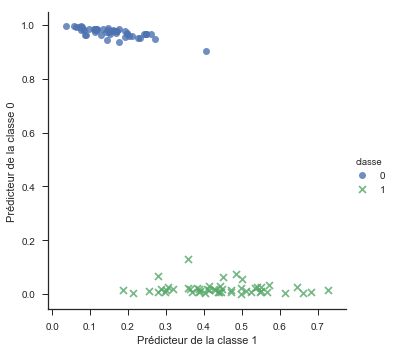

In [4]:
clf = OneVsRestClassifier(LogisticRegression()).fit(X, y)

Out = predict_proba(clf, X, normalize=False)
data = pd.DataFrame(Out, columns=['p0','p1','p2'])
data['classe'] = pd.Series(y, index=data.index)

def scatter(x, y, data=data, classes='classe',save=False):
    query = 'classe=={} or classe=={}'.format(x,y)
    xp = 'p{}'.format(x)
    yp = 'p{}'.format(y)
    df = data.query(query)
    plt1 = sns.lmplot(data=df, x=xp, y=yp, markers=["o","x"],hue=classes, fit_reg=False)
    plt1 = (plt1.set_axis_labels('Prédicteur de la classe {}'.format(x), 'Prédicteur de la classe {}'.format(y)))
    if save :
        pylab.savefig('{}_scatter_{}'.format(x,y))
    return plt

scatter(1,0, save=True)

# Post OvR processor

In [5]:
# TOOLS

def logit(x):
    return np.log(x/(1-x))

def density(params):
    m = params[0]
    s2 = params[1]
    def f(x):
        return np.exp(-(x-m)**2/(2*s2))/np.sqrt(2*np.pi*s2)
    return f

def prod(func):
    def f(l):
        output = 1
        if len(l) != len(func):
            raise error
        for f_, x in zip(func, l):
            output *= f_(x)
        return output
    return f

def sumf(func):
    def f(l):
        output = 0
        for f_ in func:
            output += f_(l)
        return output
    return f

In [6]:
# VALUES OF THE PARAMETER BETA
betas = [np.exp(i*0.5-10) for i in range(50)]

# PORTION OF TRAIN & CALIBRATION DBs
train_portion = 0.3
calib_portion = 0.3

# IF TRUE O=WI ELSE O=sigmoid(WI)
linear_model = True

In [7]:
warnings.filterwarnings("ignore")

score_train = 0
score_test = 0
score_calib = 0
all_nscore_train = np.zeros(len(betas))
all_nscore_test = np.zeros(len(betas))
all_nscore_calib = np.zeros(len(betas))

iter_ = 30
for i in range(iter_):
    
    # BUILD TRAIN, CALIBRATION & TEST DATABASES
    elem_nb = X.shape[0]
    index = list(range(elem_nb))
    random.shuffle(index)
    
    train_index = index[:int(train_portion*elem_nb)]
    calib_index = index[int(train_portion*elem_nb):int((train_portion+calib_portion)*elem_nb)]
    test_index = index[int((train_portion+calib_portion)*elem_nb):]

    X_train, y_train = X[train_index,:], y[train_index]
    X_calib, y_calib = X[calib_index,:], y[calib_index]
    X_test, y_test = X[test_index,:], y[test_index]

    X_list = [X_train, X_test, X_calib]
    y_list =  [y_train, y_test, y_calib]
    
    # DROP FEATURES WITH NULL VARIANCE
    feature_to_keep = [i for i in range(X_calib.shape[1]) if np.var(X_calib[:,i]) != 0]
    X_calib = X_calib[:,feature_to_keep]
    X_train = X_train[:,feature_to_keep]
    X_test = X_test[:,feature_to_keep]

    # TRAIN CLASSIFIER
    clf = OneVsRestClassifier(LogisticRegression(fit_intercept=False)).fit(X_train, y_train)

    # GET THE OUTPUT OF THE CLASSIFIER ON THE CALIBRATION DB
    if linear_model:
        Out = logit(predict_proba(clf, X_calib, normalize=False))
    else:
        Out = predict_proba(clf, X_calib, normalize=False)
    
    # GET THE DIMENSIONS
    K = len(X_calib[0])
    J = len(set(list(y_calib)))
    L = X_calib.shape[0]

    # INIT THE SCORES
    score_train += np.mean(clf.predict(X_train)==y_train)
    score_test += np.mean(clf.predict(X_test)==y_test)
    score_calib += np.mean(clf.predict(X_calib)==y_calib)
    nscore_train, nscore_test, nscore_calib = [], [], []

    # LOOP ON BETA VALUES
    for beta in betas:

        # GAMMA
        gamma = np.zeros((J, K, L))
        if linear_model:
            for n in range(L):
                I = X_calib[n].reshape(1, K)
                gamma[:,:,n] = np.dot(np.ones((J,1)), I)
        else:
            for n in range(L):
                I = X_calib[n].reshape(1, K)
                O = Out[n].reshape(J, 1)
                gamma[:,:,n] = np.dot(O*(1-O), I)

        # H
        h = 2*(gamma*gamma).sum(axis=2)

        # SIGMA
        sigma2 = 1 / beta * np.multiply(gamma*gamma, 1 / h[:,:, np.newaxis]).sum(axis=1)

        # Pj(O|I) & P(O|I)
        params = np.dstack((Out.transpose(), sigma2))
        Pj = np.apply_along_axis(density, axis=2, arr=params)
        Poi = np.apply_along_axis(prod, axis=0, arr=Pj).flatten()

        # SUM P(O|I) on I
        sumofP = np.apply_along_axis(sumf, axis=0, arr=Poi).flatten()[0]
        index = (np.where(y_calib==c) for c in clf.classes_)
        sumofPc = np.array([np.apply_along_axis(sumf, axis=0, arr=Poi[ind]).flatten()[0] for ind in index])

        # P(c|I) - OUTPUT OF THE POST PROCESS
        def P(j, I):
            if linear_model:
                obar = logit(predict_proba(clf, I.reshape(1,K), normalize=False)[0])
            else:
                obar = predict_proba(clf, I.reshape(1,K), normalize=False)[0]
            return sumofPc[j](obar)/sumofP(obar)

        # COMPUTE THE SCORE OF THE NEW CLF ON THE 3 DBs
        for score, X_, y_ in zip((nscore_train, nscore_test, nscore_calib), X_list, y_list):
            score.append(np.mean(np.array([np.argmax([P(j,I) for j in range(J)]) for I in X_])==y_))
    
    all_nscore = (all_nscore_train, all_nscore_test, all_nscore_calib)
    n_score = (nscore_train, nscore_test, nscore_calib)
    for all_score, score in zip(all_nscore, n_score):
        all_score += np.array(score)

score_train /= iter_
score_test /= iter_
score_calib /= iter_
all_nscore_train /= iter_
all_nscore_test /= iter_
all_nscore_calib /= iter_

# Results

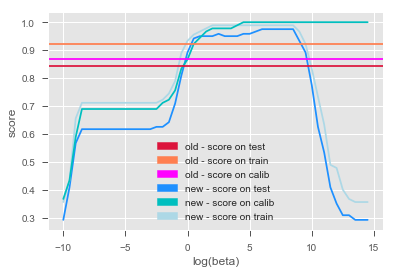

In [8]:
# PLOT

plt.style.use('ggplot')

plt.ylabel('score')
plt.xlabel('log(beta)')

x = [np.log(b) for b in betas]

plt.plot(x, all_nscore_test, color='dodgerblue')
plt.plot(x, all_nscore_train, color='lightblue')
plt.plot(x, all_nscore_calib, color='c')

plt.axhline(y=score_test, color='crimson')
plt.axhline(y=score_train, color='coral')
plt.axhline(y=score_calib, color='magenta')

red_patch = mpatches.Patch(color='crimson', label='old - score on test')
orange_patch = mpatches.Patch(color='coral', label='old - score on train')
magenta_patch = mpatches.Patch(color='magenta', label='old - score on calib')

blue_patch = mpatches.Patch(color='dodgerblue', label='new - score on test')
green_patch = mpatches.Patch(color='c', label='new - score on calib')
lightblue = mpatches.Patch(color='lightblue', label='new - score on train')

plt.legend(handles=[red_patch, orange_patch, magenta_patch, blue_patch, green_patch, lightblue])

# plt.savefig('iris_linear.png', dpi=300)